This example is based on the https://www.tensorflow.org/tutorials/audio/simple_audio.
Below I am using MFCCs to classify files instead of spectrograms that are used in the basic example.

In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython import display

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow import keras

import zipfile

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical

In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

Here I am using mini speech command dataset from kaggle
https://www.kaggle.com/code/janesser777/simple-audio-recognition-recognizing-keywords/output


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Colab Notebooks/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


I have downloaded the dataset and put it into the data_dir. After that, the file was unzipped.

In [ ]:
with zipfile.ZipFile(data_dir+'mini_speech_commands.zip', 'r') as zip_ref:
    zip_ref.extractall(data_dir)

The data_dir was changed to work with it further

In [ ]:
data_dir = os.path.join(data_dir, 'mini_speech_commands')

Using tehsorflow, we can easily define training and testing data

In [ ]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=32,
    validation_split=0.2,
    seed=0,
    output_sequence_length=None,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


MFCCs can be obtained using tensorflow standard tensorflow functions, used this
function https://www.tensorflow.org/api_docs/python/tf/signal/mfccs_from_log_mel_spectrograms with one little change

In [ ]:
def audio_to_mfccs(waveform,channels=1,sample_rate=48000):

    stfts = tf.signal.stft(waveform, frame_length=1024, frame_step=256, fft_length=1024)

    spectrograms = tf.abs(stfts)

    num_spectrogram_bins = stfts.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80, sample_rate / 2, 128
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
      num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz, upper_edge_hertz)
    mel_spectrograms = tf.tensordot(
      spectrograms, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
      linear_to_mel_weight_matrix.shape[-1:]))

    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)


    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(
      log_mel_spectrograms)[..., :13]

    return mfccs


In [ ]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

To use CNN, we have to expand dimensions for MFCCs, so they will be 3D

In [ ]:
def make_mfcc_ds(ds):
  return ds.map(
      map_func=lambda audio, label: ( tf.expand_dims(audio_to_mfccs(audio), 3, name=None), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_mfccs_ds = make_mfcc_ds(train_ds)
val_mfccs_ds = make_mfcc_ds(val_ds)

So we got the shape as shown below

In [ ]:
for example_mfccs, example_labels in train_mfccs_ds.take(1):
  print(example_mfccs.shape)

(32, 59, 13, 1)
(32, 59, 13, 1)


Defining input and output shape

In [ ]:
input_shape = example_mfccs.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)
print('Output', num_labels)

Input shape: (59, 13, 1)
Output 8


It is overly important to use normalization before modeling

In [ ]:
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_mfccs_ds.map(map_func=lambda mfccs, label: mfccs))

In [ ]:
model = Sequential()
model.add(layers.Input(shape=input_shape))
model.add(norm_layer)
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu'))
model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
model.add(Conv2D(120, kernel_size=(2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_labels, activation='softmax'))

In [ ]:
model. summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normaliza  (None, 59, 13, 1)         3         
 tion)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 58, 12, 32)        160       
                                                                 
 conv2d_15 (Conv2D)          (None, 57, 11, 48)        6192      
                                                                 
 conv2d_16 (Conv2D)          (None, 56, 10, 120)       23160     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 28, 5, 120)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 28, 5, 120)       

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 10
history = model.fit(
    train_mfccs_ds,
    validation_data=val_mfccs_ds,
    epochs=EPOCHS,
    #callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
200/200 [==============================] - 61s 284ms/step - loss: 1.7393 - accuracy: 0.3417 - val_loss: 1.1772 - val_accuracy: 0.6025
Epoch 2/10
200/200 [==============================] - 59s 289ms/step - loss: 1.2391 - accuracy: 0.5577 - val_loss: 0.8879 - val_accuracy: 0.7050
Epoch 3/10
200/200 [==============================] - 58s 285ms/step - loss: 0.9811 - accuracy: 0.6495 - val_loss: 0.7571 - val_accuracy: 0.7475
Epoch 4/10
200/200 [==============================] - 54s 266ms/step - loss: 0.8263 - accuracy: 0.7011 - val_loss: 0.7327 - val_accuracy: 0.7425
Epoch 5/10
200/200 [==============================] - 59s 289ms/step - loss: 0.7302 - accuracy: 0.7387 - val_loss: 0.6522 - val_accuracy: 0.7725
Epoch 6/10
200/200 [==============================] - 58s 283ms/step - loss: 0.6381 - accuracy: 0.7784 - val_loss: 0.6163 - val_accuracy: 0.7800
Epoch 7/10
200/200 [==============================] - 59s 291ms/step - loss: 0.5488 - accuracy: 0.8047 - val_loss: 0.6269 - val_ac

Text(0, 0.5, 'Accuracy [%]')

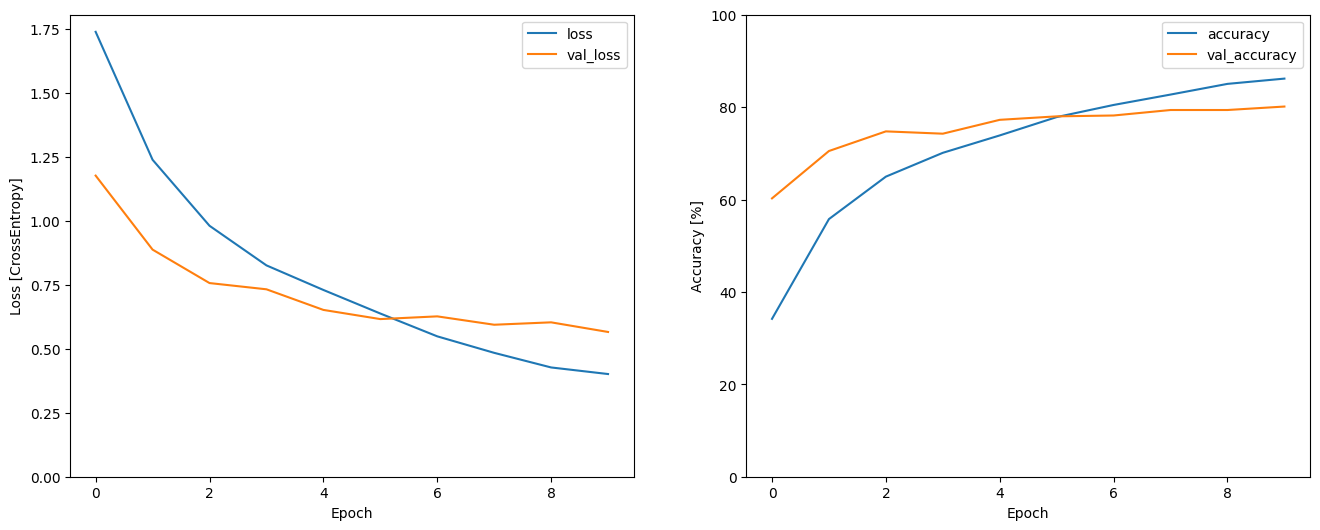

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [ ]:
model.evaluate(val_mfccs_ds, return_dict=True)

50/50 [==============================] - 8s 162ms/step - loss: 0.5659 - accuracy: 0.8012


{'loss': 0.565945565700531, 'accuracy': 0.8012499809265137}

In [ ]:
y_pred = model.predict(val_mfccs_ds)

50/50 [==============================] - 7s 128ms/step


In [ ]:
y_pred = tf.argmax(y_pred, axis=1)

In [ ]:
y_true = tf.concat(list(val_mfccs_ds.map(lambda s,lab: lab)), axis=0)

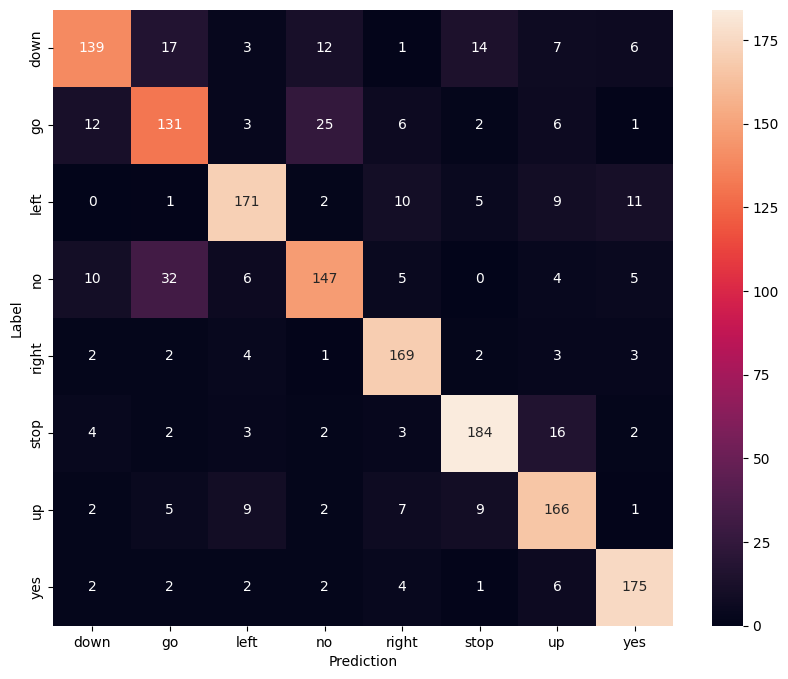

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Reading this as a table:
Diaginal elements are defined correctly

Accuracy:  Accuracy is used to measure the performance of the model. It is the ratio of Total correct instances to the total instances.

